In [1]:
%pylab inline
%load_ext autoreload

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.append('/home/students/s277665/.conda/envs/baseEnv/lib/python3.7/site-packages')
sys.path.append("/Users/francescoparino/Researchs/Mac2Mic/Util/")
sys.path.append("./")

In [3]:
import pandas as pd
import numpy as np
import scipy as spy
import os
import copy

import itertools
from glob import glob
import seaborn as sns
import matplotlib.patches as mpatches
from collections import Counter
from collections import defaultdict
from itertools import combinations

from multiprocessing import Pool
from functools import partial

from tqdm import tqdm_notebook

import collections, functools, operator 
from bidict import bidict
from sklearn.decomposition import NMF
from matplotlib.colors import LogNorm


from datetime import timedelta
import pickle
from sklearn.cluster import KMeans

blues = np.array(sns.light_palette("blue"))[[-4,-1]]
purples = np.array(sns.light_palette("purple"))[[-4,-1]]

In [4]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.colors import DivergingNorm
import matplotlib.ticker as mtick

In [5]:
from Covid_Lib_Data import readCovidDataset, readMorti
from Covid_Lib_Simulator import parameters, initialStates, oneStep

In [6]:
cPre = "r"
cAlphaDec = "g"
cAlphaCos = "b"
cTrueNew = blues[0]
cPredNew = blues[1]
cTrueCum = purples[0]
cPredCum = purples[1]

mpPre      = mpatches.Patch(color=cPre, label='Pre Lockdown', alpha=0.2)
mpAlphaDec = mpatches.Patch(color=cAlphaDec, label='Lockdown Adaptation', alpha=0.2)

mpTrueNew  = matplotlib.lines.Line2D([0], [0],color=cTrueNew, label='Deaths (data)', alpha=1)
mpPredNew  = matplotlib.lines.Line2D([0], [0],color=cPredNew, label='Deaths (model)', alpha=1)

mpTrvlBn  = matplotlib.lines.Line2D([0], [0],color="black", label='Travel Ban', alpha=1)

In [7]:
dictProvincieNS, dictRegionNS, orderedPROV, convertPROV_REG, nh, Whk, covidProv, covidRegion, covidRegionCum, covidRegionNew = readCovidDataset()
cvdRgDc_CUM, cvdRgDc_NEW = readMorti()

preDay = 23 #effective 20gg before
pre = pd.DataFrame((np.zeros((preDay, 20))), columns = cvdRgDc_CUM.columns, index=pd.date_range(cvdRgDc_CUM.index[0]-datetime.timedelta(preDay), periods=preDay, freq='1D'))
pre.loc["2020-02-21", "Lombardia"] = 1
pre.loc["2020-02-22", "Lombardia"] = 1
pre.loc["2020-02-23", "Lombardia"] = 4
pre.loc["2020-02-20", "Veneto"] = 1
pre = pre.cumsum()

cvdRgDc_CUM = cvdRgDc_CUM.append(pre).sort_index()
cvdRgDc_NEW = cvdRgDc_CUM.diff()

<AxesSubplot:>

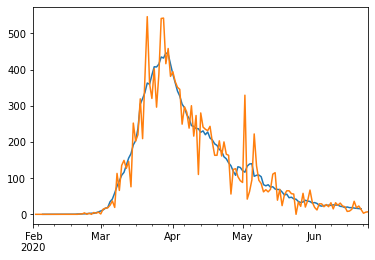

In [8]:
cvdRgDc_NEW["Lombardia"].rolling(7, center=True).mean().shift(0).dropna().plot(legend=False)
cvdRgDc_NEW["Lombardia"].plot(legend=False)

In [9]:
# Smooth
cvdRgDcRaw_NEW = cvdRgDc_NEW.copy().iloc[4:]
cvdRgDcRaw_CUM = cvdRgDc_CUM.copy().iloc[4:]
cvdRgDc_NEW = cvdRgDc_NEW.rolling(7, center=True).mean().dropna()
cvdRgDc_CUM = cvdRgDc_CUM.rolling(7, center=True).mean().dropna()

# Define Functions

In [18]:
def runTotal(SEINR, p, timeS=200, lockNord_b=None, lockSud_b=None, lockAll_alpha=None, smoothAlpha=True, getSEINR=False):
    S, E, I, N, R = SEINR
    
    time = np.arange(timeS)
    comSumForRegion = np.zeros((timeS, p.Whk.shape[0], 5))
    comSum = np.zeros((timeS, 5))
    rawSEINR = np.zeros((timeS, S.shape[0], p.Whk.shape[0], 5))
    
    
    # set and control alpha if negative
    if lockAll_alpha is not None:
        smoothDay = 15
        step = (1-p.alpha_lock)/smoothDay
        while lockAll_alpha < 0 and smoothDay>0: 
            print(f"Alpha Negative {lockAll_alpha}")
            lockAll_alpha += 1
            smoothDay -= 1
            p.alpha -= step
        
        
    # lockB negative
    if lockNord_b is not None:
        if lockNord_b < 0:  p.lockdown_b([dictProvincieNS[i] in {'Nord-ovest', 'Nord-est','Centro'} for i in orderedPROV])
    if lockSud_b is not None:
        if lockSud_b  < 0:  p.lockdown_b([dictProvincieNS[i] not in {'Nord-ovest', 'Nord-est','Centro'} for i in orderedPROV])
    

    for i in range(timeS):
        S, E, I, N, R = oneStep(SEINR,p) 
        
        rawSEINR[i] = np.dstack([S, E, I, N, R])
        comSumForRegion[i] = np.vstack([S.sum(0), E.sum(0), I.sum(0), N.sum(0), R.sum(0)]).transpose()
        comSum[i] = comSumForRegion[i].sum(0) #SEIAR
        SEINR = (S, E, I, N, R)
        
        if i == lockNord_b:
            p.lockdown_b([dictProvincieNS[i] in {'Nord-ovest', 'Nord-est','Centro'} for i in orderedPROV])
        if i == lockSud_b: 
            p.lockdown_b([dictProvincieNS[i] not in {'Nord-ovest', 'Nord-est','Centro'} for i in orderedPROV])
        
        if lockAll_alpha is not None:
            if smoothAlpha:
                if i >= lockAll_alpha and i < (lockAll_alpha+smoothDay):
                    p.alpha -= step
            else:
                if i == lockAll_alpha:
                    p.lockdown_alpha()
    
    if getSEINR: return SEINR     
    return time, comSum, comSumForRegion, rawSEINR





def getDataset(startDate, ggFit, initialEI_pos=-1, regionS=None):
    
    cvdRgDc_NEW_FIT = cvdRgDc_NEW[startDate: startDate + datetime.timedelta(days=ggFit)]
    cvdRgDc_CUM_FIT = cvdRgDc_CUM[startDate: startDate + datetime.timedelta(days=ggFit)]
    
    #Filter Regions
    if not regionS is None:
        cvdRgDc_CUM_FIT = cvdRgDc_CUM_FIT.loc[:, regionS]
        cvdRgDc_NEW_FIT = cvdRgDc_NEW_FIT.loc[:, regionS]
        
    #compute initial E,I
    initialCaseI = covidProv.iloc[initialEI_pos].values
    initialCaseE = covidProv.iloc[initialEI_pos].values
    
    realData = (cvdRgDc_CUM_FIT, cvdRgDc_NEW_FIT, initialCaseI, initialCaseE)
    return realData



def fToMin(inp, realData, dateLocks, ggFit, provinceLevel=False):
    #init
    cvdRgDc_CUM_FIT, cvdRgDc_NEW_FIT, initialCaseI, initialCaseE = realData
    Lambda, alpha_lock, b_lock, precentageE, precentageI = inp
    lockNord_b, lockSud_b, lockAll_alpha = dateLocks
    
    p = parameters(nh, Whk, Lambda=Lambda, alpha_lock=alpha_lock, b_lock=b_lock, precentageE=precentageE, precentageI=precentageI)
    SEINR = initialStates(p, initialCaseI, initialCaseE)

    #run
    time, comSum, comSumForRegion, rawSEINR = runTotal(SEINR, p, ggFit+1, lockNord_b, lockSud_b, lockAll_alpha)
    
    # crete timeseries from results
    mdlI = pd.DataFrame(comSumForRegion[:, :, 2], columns=orderedPROV)
    mdlI.index = pd.date_range(cvdRgDc_CUM_FIT.index[0], periods=len(mdlI), freq='1D') 
    
    mdlDc_CUM = pd.DataFrame((rawSEINR[:, :, :, 4] * p.mortality.reshape(1, 2, 1)).sum(1), columns=orderedPROV)
    mdlDc_CUM.index = pd.date_range(cvdRgDc_CUM_FIT.index[0], periods=len(mdlDc_CUM), freq='1D')     
    
    if provinceLevel:
        return mdlI, mdlDc_CUM
    
    # rename axix to match dataset
    mdlI.columns = [convertPROV_REG[i] for i in mdlI.columns]
    mdlI = mdlI.groupby(level=0, axis=1).sum()
    
    mdlDc_CUM.columns = [convertPROV_REG[i] for i in mdlDc_CUM.columns]
    mdlDc_CUM = mdlDc_CUM.groupby(level=0, axis=1).sum()
    
    return mdlI, mdlDc_CUM

# f to **Run Best Fit Until**

In [11]:
# Time Period Fit
initialEI_pos_BEST = -1
startDate = cvdRgDc_CUM.index[0]
ggFit_BEST = list(cvdRgDc_CUM.index).index(cvdRgDc_CUM.loc["2020-05-18"].name)

# Lock-down strategies
lockNord_b_BEST = (datetime.datetime(2020, 3, 1) - startDate).days
lockSud_b_BEST = (datetime.datetime(2020, 3, 7) - startDate).days
lockAll_alpha_BEST = (datetime.datetime(2020, 3, 5) - startDate).days

In [12]:
{'Lambda': 0.04218151748264074, 'alpha_lock': 0.17657372198907198, 'b_lock': 0.0, 'initialE': -3.6060057687708658, 'initialI': -2.1024724516951636}

{'Lambda': 0.04218151748264074,
 'alpha_lock': 0.17657372198907198,
 'b_lock': 0.0,
 'initialE': -3.6060057687708658,
 'initialI': -2.1024724516951636}

In [13]:
B_LOW_BEST = 0
ALPHA_LOW_BEST = 0.17657372198907198

Lambda = 0.04218151748264074
initialE = -3.6060057687708658
initialI = -2.1024724516951636

In [14]:
def getExperiment(lockNord_b=lockNord_b_BEST, lockSud_b=lockSud_b_BEST, lockAll_alpha=lockAll_alpha_BEST, alpha_low=ALPHA_LOW_BEST, b_low=B_LOW_BEST, ggFit=ggFit_BEST, provinceLevel=False):
    par = [Lambda,  alpha_low,  b_low, initialE, initialI]
    realData = getDataset(startDate, ggFit, initialEI_pos_BEST)
    dateLocks = lockNord_b, lockSud_b, lockAll_alpha
    
    mdlI, mdlDc_CUM = fToMin(par, realData, dateLocks, ggFit, provinceLevel=provinceLevel)
    return mdlI, mdlDc_CUM

In [15]:
def SEINRuntil(ggFit):
    B_LOW_BEST = 0
    ALPHA_LOW_BEST = 0.17657372198907198

    Lambda = 0.04218151748264074
    initialE = -3.6060057687708658
    initialI = -2.1024724516951636

    par = [Lambda,  ALPHA_LOW_BEST,  B_LOW_BEST, initialE, initialI]
    realData = getDataset(startDate, ggFit, initialEI_pos_BEST)
    dateLocks = lockNord_b_BEST, lockSud_b_BEST, lockAll_alpha_BEST
    
    cvdRgDc_CUM_FIT, cvdRgDc_NEW_FIT, initialCaseI, initialCaseE = realData
    Lambda, alpha_lock, b_lock, precentageE, precentageI = par
    
    p = parameters(nh, Whk, Lambda=Lambda, alpha_lock=alpha_lock, b_lock=b_lock, precentageE=precentageE, precentageI=precentageI)
    SEINR = initialStates(p, initialCaseI, initialCaseE)

    #run
    SEINR_end = runTotal(SEINR, p, timeS=ggFit, lockNord_b=lockNord_b_BEST, lockSud_b=lockSud_b_BEST, lockAll_alpha=lockAll_alpha_BEST, getSEINR=True)
    endDate = cvdRgDc_NEW_FIT.index.min() + datetime.timedelta(ggFit)
    return SEINR_end, endDate

# f to **Run After**

In [16]:
regColumnsAnOrder = covidRegion.columns

def runReopen(SEINR, inp, ggFit, startDate, provinceLevel=False):
    Lambda, alpha_lock, b_lock, precentageE, precentageI = inp
    
    p = parameters(nh, Whk, Lambda=Lambda, alpha_lock=alpha_lock, b_lock=b_lock, precentageE=precentageE, precentageI=precentageI)
    p.alpha = p.alpha_lock
    p.lockdown_b([True for i in orderedPROV])
    
    #print(SEIAR[1])
    time, comSum, comSumForRegion, rawSEINR = runTotal(SEINR, p, ggFit, lockNord_b=None, lockSud_b=None, lockAll_alpha=None)
        
 
    # crete timeseries from results
    mdlI = pd.DataFrame(comSumForRegion[:, :, 2], columns=orderedPROV)
    mdlI.index = pd.date_range(startDate, periods=len(mdlI), freq='1D') 
    
    mdlDc_CUM = pd.DataFrame((rawSEINR[:, :, :, 4] * p.mortality.reshape(1, 2, 1)).sum(1), columns=orderedPROV)
    mdlDc_CUM.index = pd.date_range(startDate, periods=len(mdlDc_CUM), freq='1D')     

    
    if provinceLevel:
        return mdlI, mdlDc_CUM
    
    # rename axix to match dataset
    mdlI.columns = [convertPROV_REG[i] for i in mdlI.columns]
    mdlI = mdlI.groupby(level=0, axis=1).sum()
    
    mdlDc_CUM.columns = [convertPROV_REG[i] for i in mdlDc_CUM.columns]
    mdlDc_CUM = mdlDc_CUM.groupby(level=0, axis=1).sum()
    
    return mdlI, mdlDc_CUM

    
def getExperimentReopen(alpha_open, b_open, ggFit_PRE=120, ggFit_POST=120, overwriteRealData=False):
    start_SEINR, startDate = SEINRuntil(ggFit_PRE)
    if overwriteRealData: start_SEINR = SEINR_Adapted #OVERWRITE SEIAR with the adapted one
    
    mdlI_PRE, mdlDc_CUM_PRE = getExperiment(lockNord_b_BEST, lockSud_b_BEST, lockAll_alpha_BEST, ALPHA_LOW_BEST, B_LOW_BEST, ggFit_PRE, True) 
 
    par = [Lambda,  alpha_open, b_open, initialE, initialI]
    mdlI_POST, mdlDc_CUM_POST = runReopen(start_SEINR, par, ggFit_POST, startDate, provinceLevel=True)

    #remove first day of overlap
    mdlI_POST = mdlI_POST.iloc[1:]
    mdlDc_CUM_POST = mdlDc_CUM_POST.iloc[1:] - mdlDc_CUM_PRE.iloc[-1]

    mdlI = mdlI_PRE.dropna().append(mdlI_POST)
    mdlDc_CUM = mdlDc_CUM_PRE.dropna().append(mdlDc_CUM_POST)
    
    return mdlI, mdlDc_CUM

# Surfaces ***Prevalence***

In [31]:
SAVEFIG_FOLDER = "./closeopen_complete_PREV/"
if not os.path.exists(SAVEFIG_FOLDER): os.makedirs(SAVEFIG_FOLDER)
    
def getPrevalenceMax(alpha_open, b_open, ggFit_PRE):
    mdlI, mdlDc_CUM = getExperimentReopen(alpha_open, b_open, ggFit_PRE=ggFit_PRE, ggFit_POST=60, overwriteRealData=False)
    return alpha_open, b_open, mdlDc_CUM.iloc[-1]

In [32]:
MIN_ALPHA = 0.176
MAX_ALPHA = 0.6

In [33]:
def getExpPrevalence(ggFit_PRE):
    # creade grid exp
    alphaLowGrid = np.linspace(MIN_ALPHA, MAX_ALPHA, 30)
    bLowGrid = np.linspace(0, 1, 30)

    gird = itertools.product(alphaLowGrid, bLowGrid)
    with Pool(12) as pool:
        f = partial(getPrevalenceMax, ggFit_PRE=ggFit_PRE)
        res = pool.starmap(f, gird)
    
    return res, alphaLowGrid, bLowGrid


def getLogColor(data, vmin=None, vmax=None): 
    if vmin is None: vmin=data.min().min()
    if vmax is None: vmax=data.max().max()
    
    log_norm = LogNorm(vmin=vmin, vmax=vmax)
    #cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(data.min().min())), math.ceil(math.log10(data.max().max())))]
    cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(vmin)), math.ceil(math.log10(vmax)))]
    return log_norm, cbar_ticks

In [34]:
from matplotlib import ticker
def plotExmpl(res, save=None, examp=["Milano"], suptitle="", cRed=False, applyLog=False):
    fig, axs = plt.subplots(2, int(ceil(len(examp)/2)), sharex=False, sharey=False, figsize=(int(ceil(len(examp)/2))*3.5,6))
    for _examp,ax in zip(examp, np.ravel(axs)):
        resTot = pd.DataFrame([(i, j, k[_examp]) for i,j,k in res], columns=["alpha_low", "b_low", "prevalence"]).set_index(["alpha_low", "b_low"]).unstack().droplevel(0, 1)
        resTot.sort_index(ascending=False, inplace=True)
        resTot.index = [f"{i:.3f}" for i in resTot.index]
        resTot.columns = [f"{i:.3f}" for i in resTot.columns]
        
        cmap = sns.cubehelix_palette(8, start=0, rot=-.8, gamma = .8, hue=1, light=1, as_cmap=True)
        log_norm, cbar_ticks = getLogColor(resTot)
        
        #mapp = ax.imshow(resTot, interpolation="bilinear", cmap=cmap, norm=log_norm,  extent=[0,1, MIN_ALPHA,MAX_ALPHA], aspect = 1/(MAX_ALPHA-MIN_ALPHA))
        mapp = ax.imshow(resTot, interpolation="bilinear", cmap=cmap,  extent=[0,1, MIN_ALPHA,MAX_ALPHA], aspect = 1/(MAX_ALPHA-MIN_ALPHA))
        fig.colorbar(mapp, ax=ax, fraction=0.04, pad=0.04).outline.set_visible(False)


        
        #cb = mapp.collections[0].colorbar
        #cb.set_ticks([1, 10, 100, 1000, 10000])
        #tick_locator = ticker.LogLocator(numticks=3)
        #cb.locator = tick_locator
        #cb.update_ticks()
        #sns.heatmap(resTot, ax=ax, cmap="BuPu", norm=log_norm, cbar_kws={"ticks": cbar_ticks, "label":"Deaths"})
        #sns.heatmap(resTot, ax=ax)
        
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.set_xlabel(f"$\\beta$")
        ax.set_ylabel(f"$\\alpha$")
        ax.set_title(_examp, size=12)

    plt.suptitle(suptitle, y = 1.04)
    plt.tight_layout()
    
    
    if save is not None:
        plt.savefig(f"./{SAVEFIG_FOLDER}/{save}.pdf", bbox_inches = "tight")

### Definition Tensor decomposition

In [35]:
def doMNF(tensor, nComp = 2):
    shapeOrign = tensor.shape 
    
    tensorVec = tensor.reshape(tensor.shape[0], tensor.shape[1]*tensor.shape[2])
    
    mdoelNMF = NMF(n_components=nComp)
    coeff = mdoelNMF.fit_transform(tensorVec)
    basis = mdoelNMF.components_.reshape(nComp, shapeOrign[1], shapeOrign[2])
    
    return coeff, basis

def getExpTensor(res, nComp=2):
    tensor = list()
    for _region in res[0][-1].index:
        matrixReg = pd.DataFrame([(i, j, k[_region]) for i,j,k in res], columns=["alpha_low", "b_low", "prevalence"]).set_index(["alpha_low", "b_low"]).unstack()
        matrixReg = matrixReg.values
        
        #matrixReg = np.log10(matrixReg)
        matrixReg = (matrixReg - matrixReg.min())/(matrixReg.max() - matrixReg.min())

        tensor.append(matrixReg)

    tensor = np.array(tensor)
    coeff, basis = doMNF(tensor, nComp = nComp)
    return coeff, basis

In [36]:
twoColor = np.array(sns.hls_palette(8, l=.4, s=.9))[[1,2]]
from matplotlib import colors

def array2cmpa(X):
    X = np.c_[X,ones(len(X))]
    return colors.LinearSegmentedColormap.from_list('my_colormap', X)
twoColor = array2cmpa(twoColor)

In [37]:
from adjustText import adjust_text


def plotDecomposition(res, pltRgName=False, pltScatter=False, examp=["Milano"], save=None, suptitle="", revColor=False):
    coeff, basis = getExpTensor(res)
    
    fig, axs = plt.subplots(1, basis.shape[0], sharex=False, sharey=False, figsize=(7, 3))
    n = 0
    
    vmax = 0
    vmin = 1e8
    for _basis in basis:
        vmax = max((vmax, _basis.max()))
        vmin = min((vmin, _basis.min()))
        
    
    for _basis,ax in zip(basis, np.ravel(axs)):
        resTot = pd.DataFrame(_basis, index = alphaLowGrid, columns=bLowGrid)
        resTot.sort_index(ascending=False, inplace=True)
        resTot.index = [f"{i:.3f}" for i in resTot.index]
        resTot.columns = [f"{i:.3f}" for i in resTot.columns]
        
        cmap = sns.cubehelix_palette(8, start=0, rot=-.8, gamma = .8, hue=1, light=1, as_cmap=True)
        mapp = ax.imshow(resTot, interpolation="bilinear", cmap=cmap,  extent=[0,1, MIN_ALPHA,MAX_ALPHA], aspect = 1/(MAX_ALPHA-MIN_ALPHA))
        fig.colorbar(mapp, ax=ax, fraction=0.04, pad=0.04).outline.set_visible(False)
        
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.set_xlabel(f"$\\beta$")
        ax.set_ylabel(f"$\\alpha$")
        ax.set_title(f"Component {n}")
        n += 1
    
    plt.suptitle(suptitle, y = 1.01)
    plt.tight_layout()
    
    
    if save is not None: plt.savefig(f"./{SAVEFIG_FOLDER}/{save}_components.pdf", bbox_inches = "tight")
    
    if pltRgName:
        fig, axs = plt.subplots()
        plt.scatter(coeff[:,0], coeff[:,1])
        texts = list()
        for x,y,t in (zip(coeff[:,0], coeff[:,1], res[0][-1].index)):

            texts.append(plt.text(x, y, t, ha='center', va='center'))
        adjust_text(texts, lim=10) 
        if save is not None: plt.savefig(f"./{SAVEFIG_FOLDER}/{save}_scatterText.pdf", bbox_inches = "tight")
    
    if pltScatter:
        fig, axs = plt.subplots(figsize=(4, 2.7))
        kmeans = KMeans(n_clusters=2, random_state=0).fit(coeff)
        
        plt.scatter(coeff[:,0], coeff[:,1])
        #if revColor: plt.scatter(coeff[:,0], coeff[:,1], c=kmeans.labels_, cmap=twoColor.reversed())
        #else: plt.scatter(coeff[:,0], coeff[:,1], c=kmeans.labels_, cmap=twoColor)
        #plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],c = "r", marker="x")
        
        #texts = list()
        #for x,y,t in (zip(coeff[:,0], coeff[:,1], res[0][-1].index)):
        #    if t in examp:
        #        texts.append(plt.text(x, y, t, ha='center', va='center'))
        #adjust_text(texts, lim=10) 
        
        
        plt.xlabel("Component 0")
        plt.ylabel("Component 1")
        #plt.gca().yaxis.tick_right()
        #plt.gca().yaxis.set_label_position("right")
        if save is not None: 
            plt.savefig(f"./{SAVEFIG_FOLDER}/{save}_cluster.pdf", bbox_inches = "tight")
            pickle.dump(list(zip(res[0][-1].index, kmeans.labels_)), open(f"./{SAVEFIG_FOLDER}/{save}_clusterToProvince.p", "wb" ))    
        
        
    return coeff, basis

In [38]:
restartB = pd.datetime(2020,5,2)
restartR = pd.datetime(2020,5,18)
restartA = pd.datetime(2020,8,1)
restartAA =pd.datetime(2020,9,1)

restartB = (restartB - startDate).days
restartR = (restartR - startDate).days
restartA = (restartA - startDate).days
restartAA = (restartAA - startDate).days

/opt/anaconda3/envs/bigdatalab/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/bigdatalab/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  
/opt/anaconda3/envs/bigdatalab/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/bigdatalab/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a fu

### run

In [39]:
allExp = (
(pd.datetime(2020,7,1), "7"),
(pd.datetime(2020,5,18), "518"),
(pd.datetime(2020,6,3), "63"))

/opt/anaconda3/envs/bigdatalab/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  
/opt/anaconda3/envs/bigdatalab/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/bigdatalab/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


In [40]:
%%capture
for restartA,nam in allExp:

    #restartA = pd.datetime(2020,8,1)
    #restartA = pd.datetime(2020,5,18)
    restartA = (restartA - startDate).days
    dateOpenAll = restartA

    saveName = "province_" + nam

    dateOpen = (startDate + timedelta(dateOpenAll)).strftime("%B %-d")
    suptitle=f"Relaxation on {dateOpen}"

    examp = ["Sud Sardegna", "Bergamo"]
    res, alphaLowGrid, bLowGrid = getExpPrevalence(dateOpenAll)
    plotExmpl(res,examp=examp, suptitle=suptitle, save=saveName, applyLog=True)
    
    examp = ["Sud Sardegna", "Varese", "Bergamo", "Monza e della Brianza"]
    coeff, basis = plotDecomposition(res, False, True, examp=examp, suptitle=suptitle, save=saveName)

/opt/anaconda3/envs/bigdatalab/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  
/opt/anaconda3/envs/bigdatalab/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


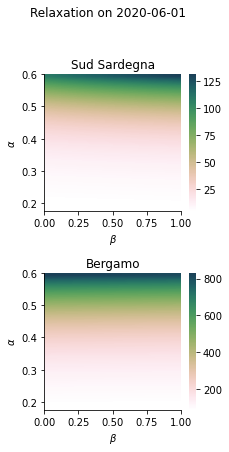

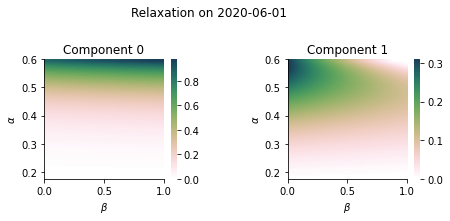

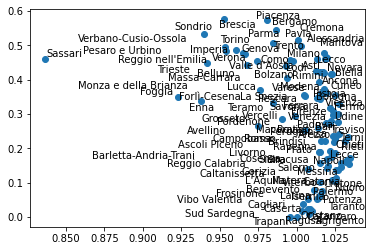

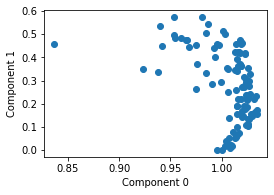

In [45]:
#restartA = pd.datetime(2020,6,1)
restartA = pd.datetime(2020,6,1)
#restartA = pd.datetime(2020,5,18)
restartA = (restartA - startDate).days
dateOpenAll = restartA

#saveName = "province_518"
saveName = "province_6"


dateOpen = (startDate + timedelta(dateOpenAll)).strftime("%Y-%m-%d")
suptitle = f"Relaxation on {dateOpen}"

examp = ["Sud Sardegna", "Bergamo"]
res, alphaLowGrid, bLowGrid = getExpPrevalence(dateOpenAll)
plotExmpl(res,examp=examp, suptitle=suptitle, save=saveName, applyLog=True)

examp = ["Sud Sardegna", "Varese", "Bergamo", "Monza e della Brianza"]
coeff, basis = plotDecomposition(res, True, True, examp=examp, suptitle=suptitle, save=saveName, revColor=False)

# OverallItaly

In [62]:
def plotExmpl(res, save=None, examp=["Italy"], suptitle="", cRed=False, applyLog=False):
    #fig, axs = plt.subplots(1, int(ceil(len(examp)/2)), sharex=False, sharey=False, figsize=(int(ceil(len(examp)/2))*3.5,3))
    fig, axs = plt.subplots(1, int(ceil(len(examp)/2)), sharex=False, sharey=False, figsize=(4,3.2))
    for _examp,ax in zip(examp, np.ravel(axs)):
        resTot = pd.DataFrame([(i, j, k[_examp]) for i,j,k in res], columns=["alpha_low", "b_low", "prevalence"]).set_index(["alpha_low", "b_low"]).unstack().droplevel(0, 1)
        resTot.sort_index(ascending=False, inplace=True)
        #resTot.index = [f"{i:.2f}" for i in resTot.index]
        #resTot.columns = [f"{i:.2f}" for i in resTot.columns]
        
        #resTot = resTot.divide(resTot.iloc[:, -1], axis=0) - 1 
        cmap = sns.cubehelix_palette(8, start=0, rot=-.8, gamma = .8, hue=1, light=1, as_cmap=True)
        log_norm, cbar_ticks = getLogColor(resTot)
        #plt.imshow(resTot, interpolation="bilinear", cmap=cmap, norm=log_norm, extent=[0,1, MIN_ALPHA,MAX_ALPHA], aspect = 1/(MAX_ALPHA-MIN_ALPHA))
        mapp = plt.imshow(resTot, interpolation="bilinear", cmap=cmap, extent=[0,1, MIN_ALPHA,MAX_ALPHA], aspect = 1/(MAX_ALPHA-MIN_ALPHA))
        #cb = plt.colorbar(label=f"Number of deaths").outline.set_visible(False)
        fig.colorbar(mapp, ax=ax, fraction=0.04, pad=0.04).outline.set_visible(False)
        
        ax.set_xlabel(f"$\\beta$")
        ax.set_ylabel(f"$\\alpha$")
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
        

        maxInd = resTot.index[np.unravel_index(resTot.values.argmax(), resTot.values.shape)[0]]
        maxCol = resTot.columns[np.unravel_index(resTot.values.argmax(), resTot.values.shape)[1]]
        maxVal = resTot.values.max()

        print(f"max value at {maxInd, maxCol}, {maxVal}")
        ax.set_title(_examp, size=12)
        
    plt.suptitle(suptitle, y = 1.04)
    plt.tight_layout()
    
    
    #matplotlib2tikz.save(f"./{SAVEFIG_FOLDER}/{save}_Italy.tex")
    plt.savefig(f"./{SAVEFIG_FOLDER}/{save}_Italy.pdf", bbox_inches = "tight")

In [63]:
SAVEFIG_FOLDER = "./closeopen_complete_PREV/"
if not os.path.exists(SAVEFIG_FOLDER): os.makedirs(SAVEFIG_FOLDER)
    
def getPrevalenceMax(alpha_open, b_open, ggFit_PRE):
    mdlI, mdlDc_CUM = getExperimentReopen(alpha_open, b_open, ggFit_PRE=ggFit_PRE, ggFit_POST=60, overwriteRealData=False)
    return alpha_open, b_open, mdlDc_CUM.iloc[-1]

In [64]:
allExp = (
(pd.datetime(2020,7,1), "7"),
(pd.datetime(2020,5,18), "518"),
(pd.datetime(2020,6,3), "63"))

/opt/anaconda3/envs/bigdatalab/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  
/opt/anaconda3/envs/bigdatalab/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/bigdatalab/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


In [65]:
%%capture
for restartA,nam in allExp:
 
    restartA = (restartA - startDate).days
    dateOpenAll = restartA

    saveName = "italy_" + nam

    dateOpen = (startDate + timedelta(dateOpenAll)).strftime("%B %-d")
    suptitle=f"Relaxation on {dateOpen}"

    res, alphaLowGrid, bLowGrid = getExpPrevalence(dateOpenAll)
    res = [(i,j,pd.Series(k.sum(0), index=["Italy"])) for i,j,k in res]
    plotExmpl(res, suptitle=suptitle, save=saveName, applyLog=True)

In [66]:
restartA = pd.datetime(2020,7,1)
restartA = (restartA - startDate).days
dateOpenAll = restartA

saveName = "province_7"


dateOpen = (startDate + timedelta(dateOpenAll)).strftime("%Y-%m-%d")
suptitle=f"Relaxation on {dateOpen}"

res, alphaLowGrid, bLowGrid = getExpPrevalence(dateOpenAll)
res = [(i,j,pd.Series(k.sum(0), index=["Italy"])) for i,j,k in res]

/opt/anaconda3/envs/bigdatalab/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


max value at (0.6, 1.0), 12675.937610010242


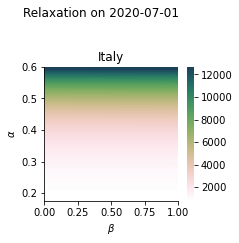

In [67]:
plotExmpl(res, suptitle=suptitle, save=saveName, applyLog=True)